## Deep Learning Final Project
***Real-Time Sports Highlight Extraction***

### Topic
- Live sports and recreational footage—from amateur league games to practice drills—often ends up as hours of unedited video. Manually sifting through this raw material to find the exciting moments (goals, tackles, sprints, key plays) is labor-intensive, error-prone, and slow, preventing broadcasters and content creators from instantly sharing highlights when viewer interest is at its peak. A real-time sports highlight extraction system addresses this by automatically detecting “sports” versus “non-sports” frames in a live or recorded video stream, then batching and exporting the sports segments as discrete clips. Under the hood, it leverages a binary action-recognition model that’s been fine-tuned to spot movement patterns like running, cycling, and other athletic activities. By integrating at the video ingest point—on-device at the camera, in the CDN edge, or in a cloud-based processing pipeline—the system can mark clip boundaries as they happen. These clips can be instantly tagged, transcoded, and published to social platforms or highlight reels, dramatically reducing turnaround time and human overhead.


### Statement
- This project will build and deploy a proof-of-concept real-time sports highlight extraction tool. It ingests a continuous video stream, applies the sports-vs-non-sports action classifier at frame-rate, and buffers detected sports segments into timestamped highlight clips. Once a segment ends, the system automatically encodes the clip, attaches relevant metadata (start/end timestamps, confidence scores), and publishes it to a downstream storage or content-delivery endpoint. By automating highlight generation, the solution aims to cut manual editing time , accelerate social media engagement, and provide content creators with an always-on, scalable highlights workflow.

### Dataset Description
- The Human Action Recognition (HAR) dataset contains over 12,000 labeled images across 15
human action categories including “fighting”, “running”, “hugging”, “sitting”, and “texting”. Each
image represents a single action, and actions are stored in separate folders. The primary variables
of interest are the image data (RGB format) and the categorical label representing the type of
human action. We divieded the topic into sports and non-sports for further analysis, as the origional dataset is too small for deep learning project regarding 15 topics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o "/content/drive/MyDrive/archive.zip"
print("Unzip complete")

Streaming output truncated to the last 5000 lines.
  inflating: Human Action Recognition/train/Image_55.jpg  
  inflating: Human Action Recognition/train/Image_550.jpg  
  inflating: Human Action Recognition/train/Image_5500.jpg  
  inflating: Human Action Recognition/train/Image_5501.jpg  
  inflating: Human Action Recognition/train/Image_5502.jpg  
  inflating: Human Action Recognition/train/Image_5503.jpg  
  inflating: Human Action Recognition/train/Image_5504.jpg  
  inflating: Human Action Recognition/train/Image_5505.jpg  
  inflating: Human Action Recognition/train/Image_5506.jpg  
  inflating: Human Action Recognition/train/Image_5507.jpg  
  inflating: Human Action Recognition/train/Image_5508.jpg  
  inflating: Human Action Recognition/train/Image_5509.jpg  
  inflating: Human Action Recognition/train/Image_551.jpg  
  inflating: Human Action Recognition/train/Image_5510.jpg  
  inflating: Human Action Recognition/train/Image_5511.jpg  
  inflating: Human Action Recognition/

In [ ]:
import os
import pandas as pd
base_dir      = '/content/Human Action Recognition'
train_csv     = os.path.join(base_dir, 'Training_set.csv')
test_csv      = os.path.join(base_dir, 'Testing_set.csv')

train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)
sports = {'running', 'fighting', 'dancing', 'cycling'}
train_df['binary_label'] = train_df['label'].apply(
    lambda x: 'sports' if x in sports else 'non_sports'
)

train_df['binary_idx'] = train_df['binary_label'].map({
    'non_sports': "0",
    'sports':     "1"
})

print(train_df[['filename', 'label', 'binary_label', 'binary_idx']])
print("\nCounts per binary class:")
print(train_df['binary_label'].value_counts())

              filename               label binary_label binary_idx
0          Image_1.jpg             sitting   non_sports          0
1          Image_2.jpg        using_laptop   non_sports          0
2          Image_3.jpg             hugging   non_sports          0
3          Image_4.jpg            sleeping   non_sports          0
4          Image_5.jpg        using_laptop   non_sports          0
...                ...                 ...          ...        ...
12595  Image_12596.jpg             sitting   non_sports          0
12596  Image_12597.jpg            clapping   non_sports          0
12597  Image_12598.jpg             sitting   non_sports          0
12598  Image_12599.jpg             dancing       sports          1
12599  Image_12600.jpg  listening_to_music   non_sports          0

[12600 rows x 4 columns]

Counts per binary class:
binary_label
non_sports    9240
sports        3360
Name: count, dtype: int64


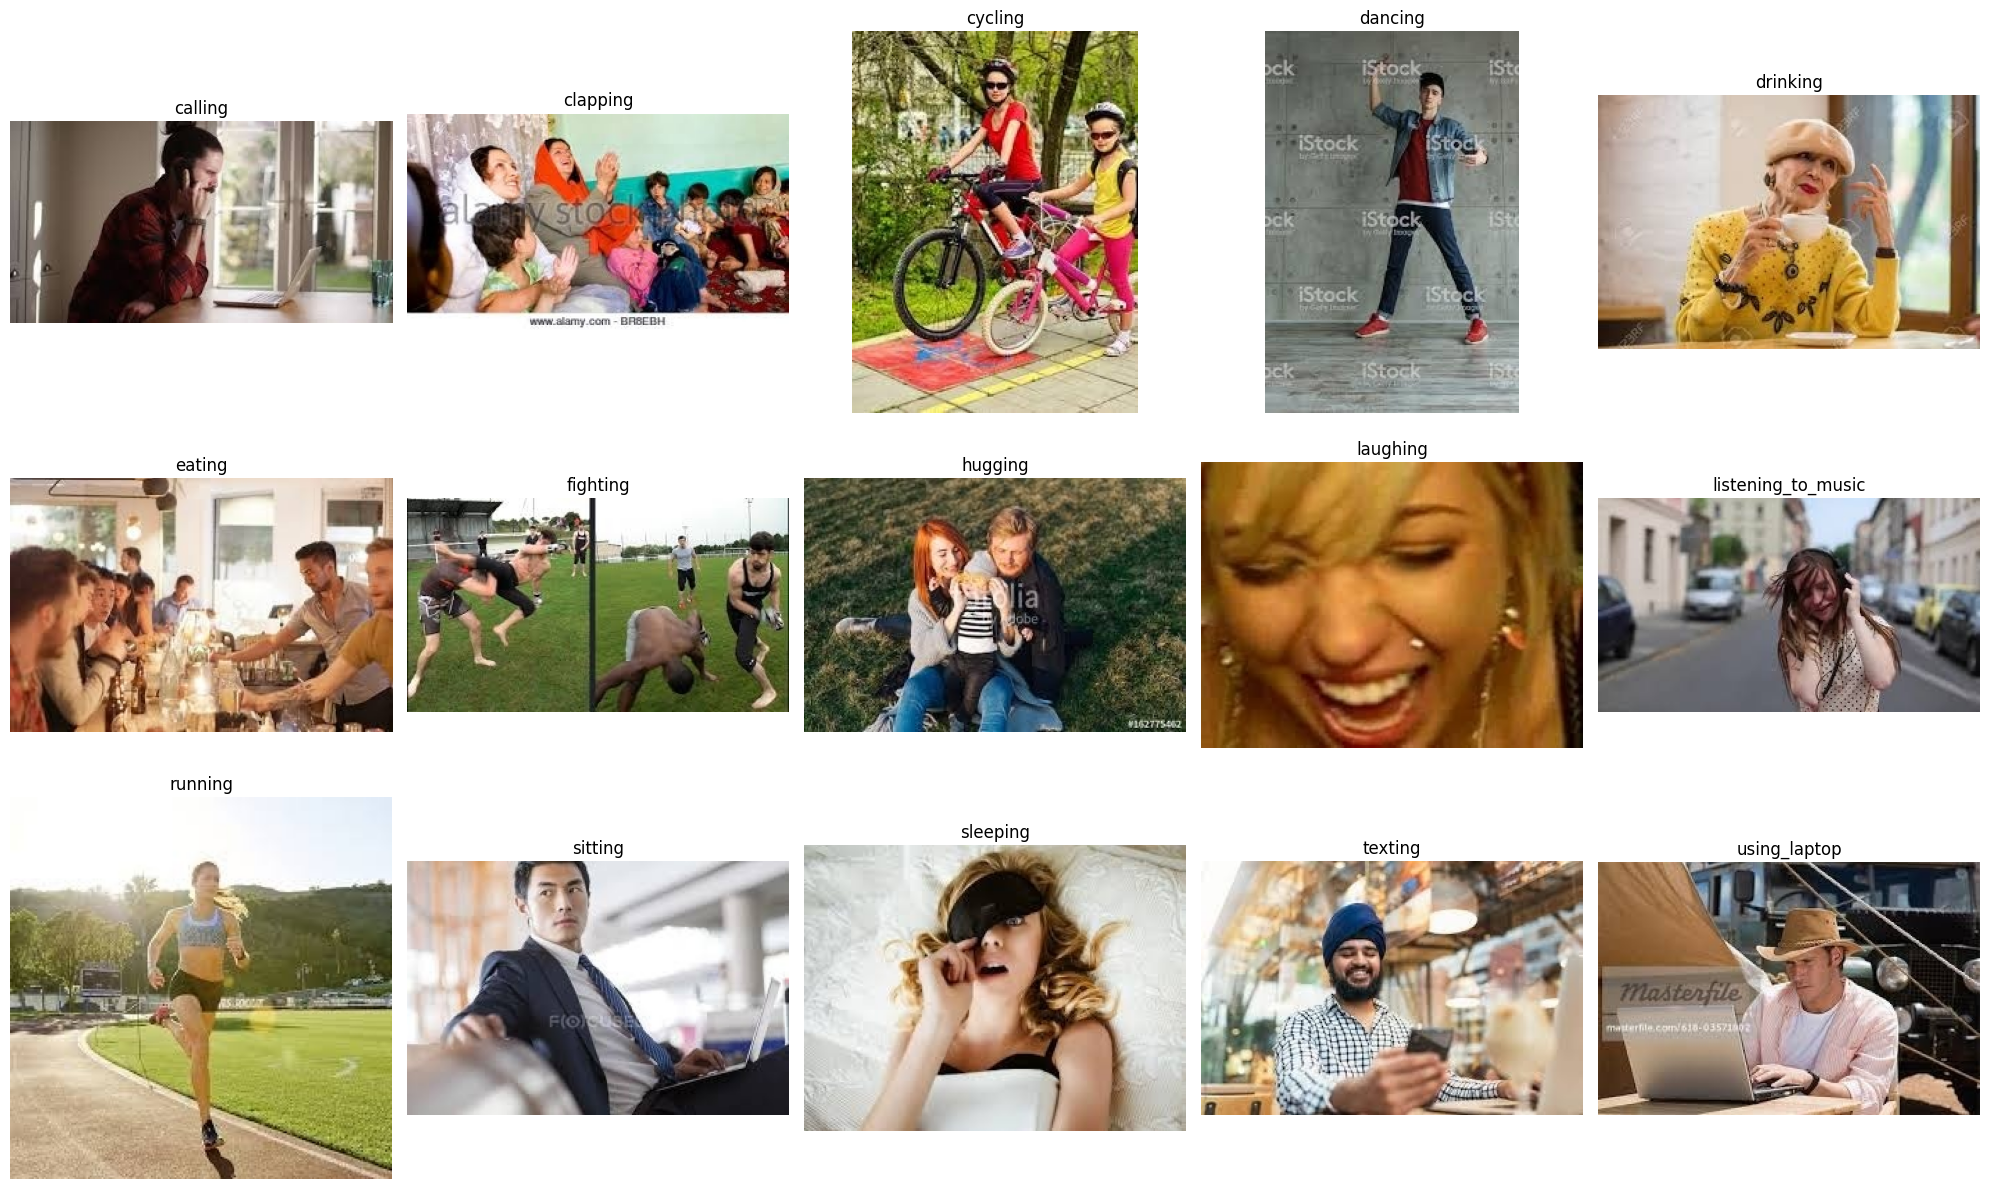

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

train_img   = os.path.join(base_dir, 'train')

labels = sorted(train_df['label'].unique())
n = len(labels)
cols = 5
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 4*rows))
for idx, label in enumerate(labels):
    sample = train_df[train_df['label']==label].sample(1).iloc[0]
    img_path = os.path.join(train_img, sample['filename'])
    img = Image.open(img_path)
    ax  = plt.subplot(rows, cols, idx+1)
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation,
    GlobalAveragePooling2D, Dense, Reshape,
    Multiply, MaxPooling2D, Dropout, InputLayer,Input, Concatenate, Layer, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
X = "filename"
Y = "binary_idx"
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df[Y], random_state=42)

print("Shape:", train_df.shape, test_df.shape)
img_dir     = "/content/Human Action Recognition/train"
target_size = (224, 224)
batch_size  = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, img_dir,
    x_col=X, y_col=Y,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    test_df, img_dir,
    x_col=X, y_col=Y,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    test_df, img_dir,
    x_col=X, y_col=Y,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Shape: (10080, 4) (2520, 4)
Found 10080 validated image filenames belonging to 2 classes.
Found 2520 validated image filenames belonging to 2 classes.
Found 2520 validated image filenames belonging to 2 classes.


## CNN+Transformer

Model: "CNN_Transformer_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ activation_4[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_sequence         │ (None, 784, 256)  │          0 │ max_pooling2d_5[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 784, 256)  │          0 │ to_sequence[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 784, 256)  │  1,051,904 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_mha_0 (Add)    │ (None, 784, 256)  │          0 │ add_1[0][0],      │
│                     │                   │            │ mha_0[0][0]     

 Total params: 1,754,497 (6.69 MB)

 Trainable params: 1,753,601 (6.69 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 170s 958ms/step - accuracy: 0.7257 - loss: 0.5859 - val_accuracy: 0.6742 - val_loss: 0.6343
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 110s 697ms/step - accuracy: 0.7828 - loss: 0.4894 - val_accuracy: 0.7413 - val_loss: 0.6001
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 111s 700ms/step - accuracy: 0.7944 - loss: 0.4626 - val_accuracy: 0.7849 - val_loss: 0.4759
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 110s 696ms/step - accuracy: 0.8009 - loss: 0.4561 - val_accuracy: 0.7230 - val_loss: 0.5714
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 111s 701ms/step - accuracy: 0.8002 - loss: 0.4615 - val_accuracy: 0.6992 - val_loss: 0.5886
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 110s 698ms/step - accuracy: 0.8117 - loss: 0.4424 - val_accuracy: 0.7996 - val_loss: 0.4590
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 110s 698ms/step - accuracy: 0.8057 - loss: 0.4371 - val_accuracy: 0.6790 - val_loss: 0.6222
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 111s 701ms/step - accuracy: 0.8158 -

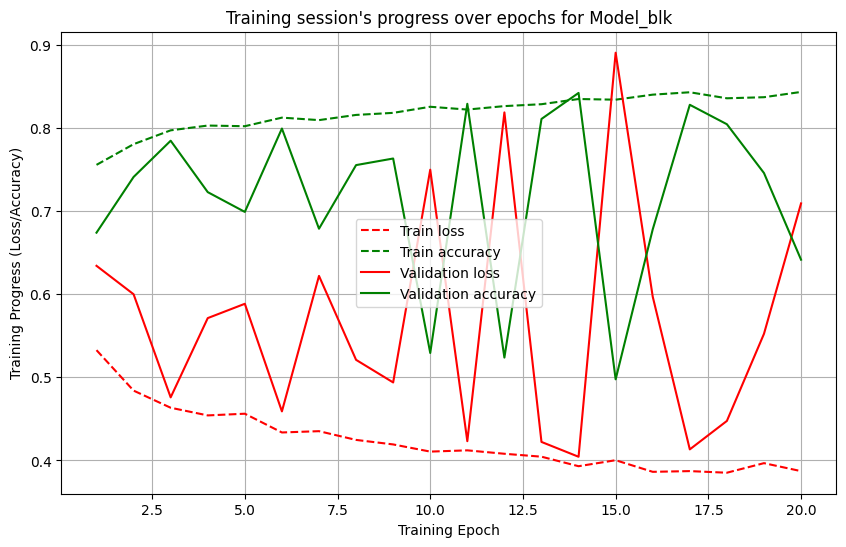

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    Reshape, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding

# --- Hyperparameters ---
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS = 3

# After 3 × 2×2 poolings: 224 → 112 → 56 → 28
TOKEN_H = IMG_HEIGHT // 8
TOKEN_W = IMG_WIDTH  // 8
SEQ_LEN = TOKEN_H * TOKEN_W  # 28 × 28 = 784
EMBED_DIM = 256
NUM_HEADS = 4
MLP_UNITS = [512, EMBED_DIM]
NUM_TRANSFORMER_BLOCKS = 1
DROPOUT_RATE = 0.3
L2 = 1e-4

def build_cnn_transformer():
    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")
    x = inp

    # --- 1) CNN backbone: 3 Conv→BN→ReLU→Pool blocks ---
    for filters in [64, 128, EMBED_DIM]:
        x = Conv2D(
            filters, 3, padding='same',
            kernel_regularizer=regularizers.l2(L2)
        )(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)
    # x.shape = (batch, 28, 28, EMBED_DIM)

    # --- 2) Flatten spatial dims into sequence of tokens ---
    x = Reshape((SEQ_LEN, EMBED_DIM), name="to_sequence")(x)

    # --- 3) Add a learnable positional embedding ---
    position_indices = tf.range(start=0, limit=SEQ_LEN, delta=1)
    pos_embedding_layer = Embedding(input_dim=SEQ_LEN, output_dim=EMBED_DIM)
    x = x + pos_embedding_layer(position_indices)


    # --- 4) Transformer encoder blocks ---
    for i in range(NUM_TRANSFORMER_BLOCKS):
        # 4.1 Multi-head Self-Attention
        attn_output = MultiHeadAttention(
            num_heads=NUM_HEADS,
            key_dim=EMBED_DIM,
            name=f"mha_{i}"
        )(x, x)
        x = Add(name=f"skip_mha_{i}")([x, attn_output])
        x = LayerNormalization(name=f"ln1_{i}")(x)

        # 4.2 Feed-Forward / MLP
        mlp = Dense(MLP_UNITS[0], activation="relu", name=f"mlp_fc1_{i}")(x)
        mlp = Dropout(DROPOUT_RATE, name=f"mlp_do_{i}")(mlp)
        mlp = Dense(MLP_UNITS[1], name=f"mlp_fc2_{i}")(mlp)
        x = Add(name=f"skip_mlp_{i}")([x, mlp])
        x = LayerNormalization(name=f"ln2_{i}")(x)

    # --- 5) Pool across the token dimension ---
    x = GlobalAveragePooling1D(name="gap_tokens")(x)

    # --- 6) Classification head ---
    x = Dense(256, activation="relu", name="head_fc")(x)
    x = Dropout(DROPOUT_RATE, name="head_do")(x)
    out = Dense(1, activation="sigmoid", name="predictions")(x)

    model = Model(inputs=inp, outputs=out, name="CNN_Transformer_Hybrid")
    return model

# Instantiate, compile, and view summary
model = build_cnn_transformer()
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


history_a = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

hist = history_a.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(10, 6))
# Training curves (dashed)
plt.plot(epochs, hist['loss'],   'r--', label='Train loss')
plt.plot(epochs, hist['accuracy'], 'g--', label='Train accuracy')
# Validation curves (solid)
plt.plot(epochs, hist['val_loss'],   'r-', label='Validation loss')
plt.plot(epochs, hist['val_accuracy'], 'g-', label='Validation accuracy')

plt.xlabel('Training Epoch')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.title("Training session's progress over epochs for Model_blk")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("/content/my_model_CNN.h5")
from google.colab import files
files.download("/content/my_model_CNN.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### CNN + Transformer Contunued by tuning
- **The version we analyzed in our report**

Model: "CNN_Transformer_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 112, 112,  │          0 │ activation_24[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_27… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 56, 56,    │          0 │ activation_25[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_28… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 28, 28,    │          0 │ activation_26[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_sequence         │ (None, 784, 256)  │          0 │ max_pooling2d_29… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 784, 256)  │          0 │ to_sequence[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 784, 256)  │  1,051,904 │ add_9[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_mha_0 (Add)    │ (None, 784, 256)  │          0 │ add_9[0][0],      │
│                     │                   │            │ mha_0[0][0]     

 Total params: 3,070,337 (11.71 MB)

 Trainable params: 3,069,441 (11.71 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 139s 781ms/step - accuracy: 0.7307 - loss: 0.6005 - val_accuracy: 0.5571 - val_loss: 0.7886
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 685ms/step - accuracy: 0.7550 - loss: 0.5265 - val_accuracy: 0.7361 - val_loss: 0.6011
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 683ms/step - accuracy: 0.7898 - loss: 0.4786 - val_accuracy: 0.6595 - val_loss: 0.6728
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 684ms/step - accuracy: 0.7878 - loss: 0.4706 - val_accuracy: 0.7611 - val_loss: 0.4937
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 685ms/step - accuracy: 0.7777 - loss: 0.4834 - val_accuracy: 0.7226 - val_loss: 0.5580
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 683ms/step - accuracy: 0.8007 - loss: 0.4758 - val_accuracy: 0.6897 - val_loss: 0.5895
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 688ms/step - accuracy: 0.8046 - loss: 0.4604 - val_accuracy: 0.7690 - val_loss: 0.4903
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 689ms/step - accuracy: 0.7974 -

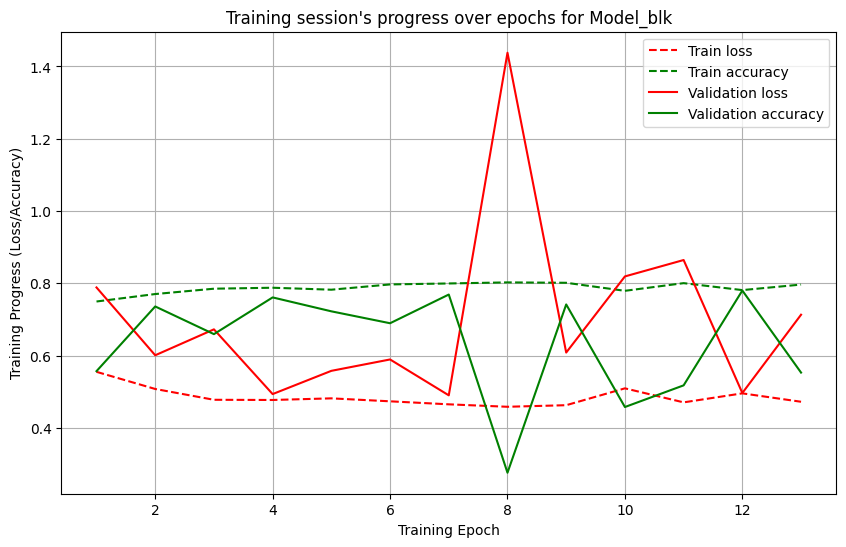

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    Reshape, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding

# --- Hyperparameters ---
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS = 3

# After 3 × 2×2 poolings: 224 → 112 → 56 → 28
TOKEN_H = IMG_HEIGHT // 8
TOKEN_W = IMG_WIDTH  // 8
SEQ_LEN = TOKEN_H * TOKEN_W  # 28 × 28 = 784
EMBED_DIM = 256
NUM_HEADS = 4
MLP_UNITS = [512, EMBED_DIM]
NUM_TRANSFORMER_BLOCKS = 2
DROPOUT_RATE = 0.5
L2 = 1e-4

def build_cnn_transformer():
    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")
    x = inp

    # --- 1) CNN backbone: 3 Conv→BN→ReLU→Pool blocks ---
    for filters in [64, 128, EMBED_DIM]:
        x = Conv2D(
            filters, 3, padding='same',
            kernel_regularizer=regularizers.l2(L2)
        )(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)
    # x.shape = (batch, 28, 28, EMBED_DIM)

    # --- 2) Flatten spatial dims into sequence of tokens ---
    x = Reshape((SEQ_LEN, EMBED_DIM), name="to_sequence")(x)

    # --- 3) Add a learnable positional embedding ---
    position_indices = tf.range(start=0, limit=SEQ_LEN, delta=1)
    pos_embedding_layer = Embedding(input_dim=SEQ_LEN, output_dim=EMBED_DIM)
    x = x + pos_embedding_layer(position_indices)


    # --- 4) Transformer encoder blocks ---
    for i in range(NUM_TRANSFORMER_BLOCKS):
        # 4.1 Multi-head Self-Attention
        attn_output = MultiHeadAttention(
            num_heads=NUM_HEADS,
            key_dim=EMBED_DIM,
            name=f"mha_{i}"
        )(x, x)
        x = Add(name=f"skip_mha_{i}")([x, attn_output])
        x = LayerNormalization(name=f"ln1_{i}")(x)

        # 4.2 Feed-Forward / MLP
        mlp = Dense(MLP_UNITS[0], activation="relu", name=f"mlp_fc1_{i}")(x)
        mlp = Dropout(DROPOUT_RATE, name=f"mlp_do_{i}")(mlp)
        mlp = Dense(MLP_UNITS[1], name=f"mlp_fc2_{i}")(mlp)
        x = Add(name=f"skip_mlp_{i}")([x, mlp])
        x = LayerNormalization(name=f"ln2_{i}")(x)

    # --- 5) Pool across the token dimension ---
    x = GlobalAveragePooling1D(name="gap_tokens")(x)

    # --- 6) Classification head ---
    x = Dense(256, activation="relu", name="head_fc")(x)
    x = Dropout(DROPOUT_RATE, name="head_do")(x)
    out = Dense(1, activation="sigmoid", name="predictions")(x)

    model = Model(inputs=inp, outputs=out, name="CNN_Transformer_Hybrid")
    return model

# Instantiate, compile, and view summary
model = build_cnn_transformer()
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


history_a = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

hist = history_a.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(10, 6))
# Training curves (dashed)
plt.plot(epochs, hist['loss'],   'r--', label='Train loss')
plt.plot(epochs, hist['accuracy'], 'g--', label='Train accuracy')
# Validation curves (solid)
plt.plot(epochs, hist['val_loss'],   'r-', label='Validation loss')
plt.plot(epochs, hist['val_accuracy'], 'g-', label='Validation accuracy')

plt.xlabel('Training Epoch')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.title("Training session's progress over epochs for Model_blk")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("/content/my_model_CNN_2.h5")
from google.colab import files
files.download("/content/my_model_CNN_2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ConBlk

Model: "HARCNN_429"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_conv (Conv2D)  │ (None, 224, 224,  │        896 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_bn             │ (None, 224, 224,  │        128 │ blk1_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_act            │ (None, 224, 224,  │          0 │ blk1_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_drop (Dropout) │ (None, 224, 224,  │          0 │ blk1_act[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_conv (Conv2D)  │ (None, 224, 224,  │      9,248 │ blk1_drop[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_bn             │ (None, 224, 224,  │        128 │ blk2_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_act            │ (None, 224, 224,  │          0 │ blk2_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_drop (Dropout) │ (None, 224, 224,  │          0 │ blk2_act[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk3_conv (Conv2D)  │ (None, 224, 224,  │     18,496 │ blk2_drop[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk3_bn             │ (None, 224, 224,  │        256 │ blk3_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk3_act            │ (None, 224, 224,  │          0 │ blk3_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk3_drop (Dropout) │ (None, 224, 224,  │          0 │ blk3_act[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk4_conv (Conv2D)  │ (None, 224, 224,  │     36,928 │ blk3_drop[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk4_bn             │ (None, 224, 224,  │        256 │ blk4_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk4_act            │ (None, 224, 224,  │          0 │ blk4_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk4_drop (Dropout) │ (None, 224, 224,  │          0 │ blk4_act[0][0]  

 Total params: 2,415,521 (9.21 MB)

 Trainable params: 2,412,833 (9.20 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 173s 849ms/step - accuracy: 0.7351 - loss: 0.7472 - val_accuracy: 0.7421 - val_loss: 0.7422 - learning_rate: 0.0010
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 690ms/step - accuracy: 0.7823 - loss: 0.5989 - val_accuracy: 0.7345 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 687ms/step - accuracy: 0.7959 - loss: 0.5562 - val_accuracy: 0.7595 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 685ms/step - accuracy: 0.8022 - loss: 0.5213 - val_accuracy: 0.7746 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 690ms/step - accuracy: 0.8055 - loss: 0.5035 - val_accuracy: 0.7405 - val_loss: 0.5643 - learning_rate: 0.0010
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 687ms/step - accuracy: 0.8117 - loss: 0.4915 - val_accuracy: 0.7845 - val_loss: 0.5407 - learning_rate: 0.0010
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 109s 690ms/step - accura

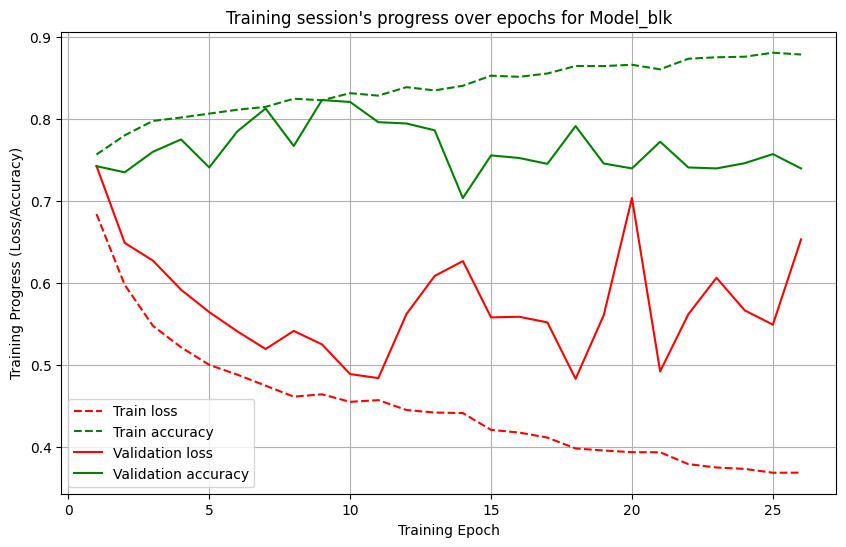

In [ ]:
input_shape = (224, 224, 3)
num_classes = 1
drop_rate = 0.3        # Stronger dropout
fc_drop   = 0.5
l2_reg    = 1e-4      # more weight penalty

# Conv block definition
def conv_blk(x, filters, name=None, l2=l2_reg):
    x = Conv2D(
        filters, 3, padding='same',
        kernel_regularizer=regularizers.l2(l2),
        name=f"{name}_conv"
    )(x)
    x = BatchNormalization(name=f"{name}_bn")(x)
    x = Activation('relu', name=f"{name}_act")(x)
    x = Dropout(drop_rate, name=f"{name}_drop")(x)
    return x


inp = Input(shape=input_shape, name="input_image")

# ConvBlk 1–2
x = conv_blk(inp, 32, name="blk1")
x = conv_blk(x, 32, name="blk2")

# ConvBlk 3–4 → concat → pool1
b3 = conv_blk(x, 64, name="blk3")
b4 = conv_blk(b3, 64, name="blk4")
c1 = Concatenate(name="concat34")([b3, b4])
p1 = MaxPooling2D(pool_size=2, name="pool1")(c1)

# ConvBlk 5
x = conv_blk(p1, 128, name="blk5")

# ConvBlk 6–7 → concat → pool2
b6 = conv_blk(x, 128, name="blk6")
b7 = conv_blk(b6, 128, name="blk7")
c2 = Concatenate(name="concat67")([b6, b7])
p2 = MaxPooling2D(pool_size=2, name="pool2")(c2)

# ConvBlk 8
x = conv_blk(p2, 256, name="blk8")

# ConvBlk 9–10 → concat → pool3
b9 = conv_blk(x, 256, name="blk9")
b10 = conv_blk(b9, 256, name="blk10")
c3 = Concatenate(name="concat9_10")([b9, b10])
p3 = MaxPooling2D(pool_size=2, name="pool3")(c3)

# Classification head
x = GlobalAveragePooling2D(name="gap")(p3)
x = Dense(256, activation='relu', name="fc1")(x)
x = Dropout(fc_drop, name="fc1_dropout")(x)
out = Dense(1, activation='sigmoid', name="predictions")(x)

# --- 4) Compile model ---
model_501_1 = Model(inputs=inp, outputs=out, name="HARCNN_429")

loss_fn = BinaryCrossentropy(label_smoothing=0.05)

model_501_1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

model_501_1.summary()

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history_blk = model_501_1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[es, lr_sched],
    verbose=1
)

hist = history_blk.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(10, 6))
# Training curves (dashed)
plt.plot(epochs, hist['loss'],   'r--', label='Train loss')
plt.plot(epochs, hist['accuracy'], 'g--', label='Train accuracy')
# Validation curves (solid)
plt.plot(epochs, hist['val_loss'],   'r-', label='Validation loss')
plt.plot(epochs, hist['val_accuracy'], 'g-', label='Validation accuracy')

plt.xlabel('Training Epoch')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.title("Training session's progress over epochs for Model_blk")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
model_501_1.save("/content/my_model_blk.h5")
from google.colab import files
files.download("/content/my_model_blk.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparison

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Dropout,
    Concatenate, MaxPooling2D, GlobalAveragePooling2D, Dense,
    Reshape, LayerNormalization, MultiHeadAttention,
    Add, GlobalAveragePooling1D
)
import tensorflow as tf


In [ ]:
def build_cnn_transformer():
    inp = Input(shape=(224, 224, 3), name="image_input")
    x = inp

    # --- 1) CNN backbone: 3 Conv → BN → ReLU → Pool blocks ---
    for i, filters in enumerate([64, 128, 256]):
        x = Conv2D(filters, 3, padding='same', name=f"conv2d_{i+3}")(x)
        x = BatchNormalization(name=f"batch_normalization_{i+3}")(x)
        x = Activation('relu', name=f"activation_{i+3}")(x)
        x = MaxPooling2D(pool_size=2, name=f"max_pooling2d_{i+3}")(x)

    # --- 2) Reshape to sequence ---
    x = Reshape((28 * 28, 256), name="to_sequence")(x)

    # --- 3) Positional Embedding omitted (was fixed vector or added externally)

    # --- 4) Transformer block ---
    attn_output = MultiHeadAttention(num_heads=4, key_dim=256, name="mha_0")(x, x)
    x = Add(name="skip_mha_0")([x, attn_output])
    x = LayerNormalization(name="ln1_0")(x)

    mlp = Dense(512, activation="relu", name="mlp_fc1_0")(x)
    mlp = Dropout(0.3, name="mlp_do_0")(mlp)
    mlp = Dense(256, name="mlp_fc2_0")(mlp)
    x = Add(name="skip_mlp_0")([x, mlp])
    x = LayerNormalization(name="ln2_0")(x)

    # --- 5) Pooling + Classifier ---
    x = GlobalAveragePooling1D(name="gap_tokens")(x)
    x = Dense(256, activation="relu", name="head_fc")(x)
    x = Dropout(0.3, name="head_do")(x)
    out = Dense(1, activation="sigmoid", name="predictions")(x)

    return Model(inputs=inp, outputs=out, name="cnn_transformer_reconstructed")
base_model = build_cnn_transformer()
base_model.load_weights("my_model_CNN.h5")
base_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
def build_concat_cnn_model():
    def conv_blk(x, filters, name=None, drop_rate=0.3, l2_reg=1e-4):
        x = Conv2D(filters, 3, padding='same',
                   kernel_regularizer=regularizers.l2(l2_reg),
                   name=f"{name}_conv")(x)
        x = BatchNormalization(name=f"{name}_bn")(x)
        x = Activation('relu', name=f"{name}_act")(x)
        x = Dropout(drop_rate, name=f"{name}_drop")(x)
        return x

    inp = Input(shape=(224, 224, 3), name="input_image")

    x = conv_blk(inp, 32, name="blk1")
    x = conv_blk(x, 32, name="blk2")

    b3 = conv_blk(x, 64, name="blk3")
    b4 = conv_blk(b3, 64, name="blk4")
    c1 = Concatenate(name="concat34")([b3, b4])
    p1 = MaxPooling2D(pool_size=2, name="pool1")(c1)

    x = conv_blk(p1, 128, name="blk5")
    b6 = conv_blk(x, 128, name="blk6")
    b7 = conv_blk(b6, 128, name="blk7")
    c2 = Concatenate(name="concat67")([b6, b7])
    p2 = MaxPooling2D(pool_size=2, name="pool2")(c2)

    x = conv_blk(p2, 256, name="blk8")
    b9 = conv_blk(x, 256, name="blk9")
    b10 = conv_blk(b9, 256, name="blk10")
    c3 = Concatenate(name="concat9_10")([b9, b10])
    p3 = MaxPooling2D(pool_size=2, name="pool3")(c3)

    x = GlobalAveragePooling2D(name="gap")(p3)
    x = Dense(256, activation='relu', name="fc1")(x)
    x = Dropout(0.5, name="fc1_dropout")(x)
    out = Dense(1, activation='sigmoid', name="predictions")(x)

    return Model(inputs=inp, outputs=out, name="Advanced_Concat_CNN")

advanced_model = build_concat_cnn_model()
advanced_model.load_weights("my_model_blk.h5")
advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step
📊 Base CNN+Transformer Metrics:
              precision    recall  f1-score   support

           0     0.8736    0.9199    0.8962      1848
           1     0.7422    0.6339    0.6838       672

    accuracy                         0.8437      2520
   macro avg     0.8079    0.7769    0.7900      2520
weighted avg     0.8385    0.8437    0.8395      2520

📊 Advanced Concat-CNN Metrics:
              precision    recall  f1-score   support

           0     0.7831    0.9886    0.8740      1848
           1     0.8877    0.2470    0.3865       672

    accuracy                         0.7909      2520
   macro avg     0.8354    0.6178    0.6302      2520
weighted avg     0.8110    0.7909    0.7440      2520



Accuracy  Precision    Recall  F1-score
Base CNN+Transformer  0.843651   0.742160  0.633929  0.683788
Advanced Concat-CNN   0.790873   0.887701  0.247024  0.386496

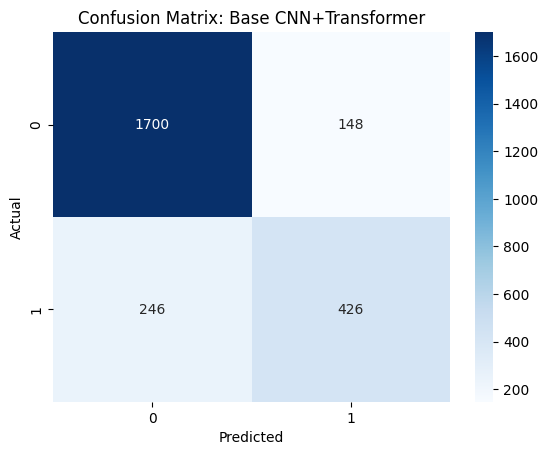

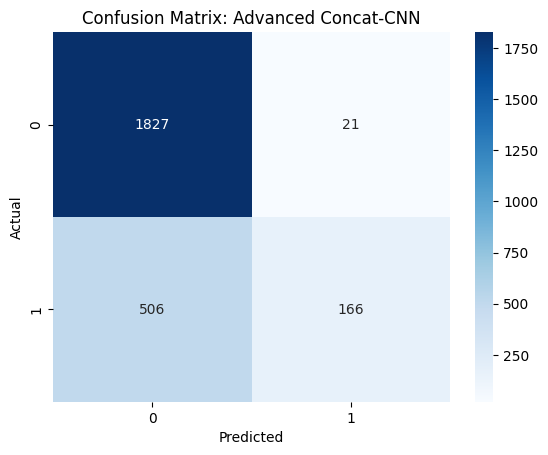

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get labels
y_test = test_gen.classes

# 2. Test Data Fitting
y_pred_base = (base_model.predict(test_gen) > 0.5).astype(int).flatten()
y_pred_adv  = (advanced_model.predict(test_gen) > 0.5).astype(int).flatten()

# 3. Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"📊 {model_name} Metrics:")
    print(classification_report(y_true, y_pred, digits=4))
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

# 4. Model evaluation
metrics_base = evaluate_model(y_test, y_pred_base, "Base CNN+Transformer")
metrics_adv  = evaluate_model(y_test, y_pred_adv, "Advanced Concat-CNN")

# 5. Concate as Dataframe
comparison_df = pd.DataFrame({
    'Base CNN+Transformer': metrics_base,
    'Advanced Concat-CNN': metrics_adv
}).T
display(comparison_df)

# 6. Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred_base, "Base CNN+Transformer")
plot_confusion_matrix(y_test, y_pred_adv, "Advanced Concat-CNN")
